In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as ss

import yfinance as yf
import pandas_market_calendars as mcal


# Data

In [2]:
asset2ticker = {asset:(asset+'-USD') for asset in ['BTC','ETH','SOL','BNB']}

kw = {}
for asset, ticker in asset2ticker.items():
    kw[asset] = yf.Ticker(ticker).history(period='1y')['Close']
df_close = pd.concat(kw, axis=1)

# this is the close prices
df_close.tail(5)

,BTC,ETH,SOL,BNB
Date,,,,
2022-08-19,20877.552734,1612.987305,35.890259,279.718719
2022-08-20,21166.060547,1577.003784,35.269733,283.693146
2022-08-21,21534.121094,1619.318970,36.533199,302.056274
2022-08-22,21398.908203,1622.505859,35.474380,300.559113
2022-08-23,21527.796875,1650.669067,35.373348,298.649536


In [3]:
# Create a calendar
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=df_close.index[0], end_date=df_close.index[-1])
valid_dates = [datetime(d.year, d.month, d.day) for d in valid_dates]
df_price = df_close.loc[valid_dates]

# Portfolio
 BTC: 0.5, ETH: 8.0, SOL: 100.0, BNB: 50.

In [4]:
class Portfolio:
    def __init__(self, kw_asset2holding):
        self.ds_asset2holding = pd.Series(kw_asset2holding)
    
    def calculate_present_value(self, df_price: pd.DataFrame):

        # prices for the asset holdings, to assign them
        df_pa = df_price[self.ds_asset2holding.index]
        return (df_pa * self.ds_asset2holding).sum(axis=1)


    def calculate_weights(self, df_price: pd.DataFrame):

        # prices for the asset holdings, to assign them
        df_pa = df_price[self.ds_asset2holding.keys()]
        return (df_pa * self.ds_asset2holding) / self.calculate_present_value(df_pa).to_numpy()[:,np.newaxis]


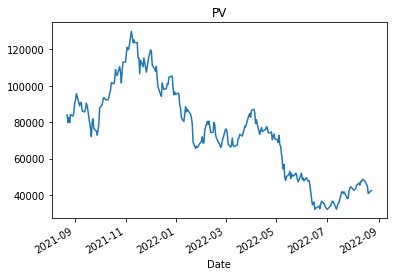

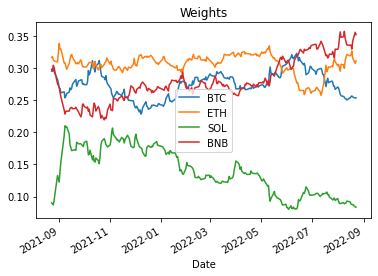

In [5]:
asset2holding = {'BTC':0.5, 'ETH':8.0, 'SOL':100.0, 'BNB':50.0}
port = Portfolio(asset2holding)
ds_pv = port.calculate_present_value(df_price)
df_weights = port.calculate_weights(df_price)

ds_pv.plot(title='PV')
plt.show()
df_weights.plot(title='Weights')
plt.show()


# VaR

In [6]:
# implement the following methods
# 1. normal model. calculate VCV and scale by inverse normal
# 2. for each risk factor, calculate the 'risk weight' at each confidence level and use a common correlation matrix to aggregate
# 3. standard historical VaR
# 4. monte carlo, asymmetric VaR

# let's return negative number as VaR

class VaR:
    def __init__(self, df_price: pd.DataFrame, n_window, n_horizon=1):
        self.df_pw = df_price.iloc[-n_window:] # cut to the relevant period
        self.ds_p0 = df_price.iloc[-1] # the t0 value
        # calculate relative returns
        self.df_rtrn = self.df_pw.diff(n_horizon).shift(-n_horizon)/self.df_pw
        # then, scale by the 't0' price
        self.df_rtrn = df_price.iloc[-1] * self.df_rtrn
        self.df_rtrn.dropna(inplace=True)

        # keep the correlation matrix as we will use this all the time
        self.df_corr = self.df_rtrn.corr() # pearson method
        self.df_cov = self.df_rtrn.cov()
        self.ds_mean = self.df_rtrn.mean()
        self.ds_med = self.df_rtrn.median()

    def calculate_parametric_var_std(self, asset2holding: dict, confidence_levels: list) -> list:
        # change the asset2holding to series
        ds_a2h = pd.Series(asset2holding)
        keys = ds_a2h.index
        df_cov = self.df_cov.loc[keys,keys]
        variance = ds_a2h.to_numpy() @ (df_cov.to_numpy() @ ds_a2h.to_numpy())
        var_std = np.sqrt(variance)
        mu = (self.ds_mean[keys] * ds_a2h).sum()
        return [mu - ss.norm.ppf(cf)*var_std for cf in confidence_levels]

    def calculate_historical_var(self, asset2holding: dict, confidence_levels: list) -> list:
        ds_a2h = pd.Series(asset2holding)
        keys = ds_a2h.index
        # calculate P&Ls
        ds_pnl = (self.df_rtrn[keys] * ds_a2h).sum(axis=1)
        # VaR is for the lower quantiles (1 - cl)
        return [np.quantile(ds_pnl, 1.0-cl) for cl in confidence_levels], ds_pnl

    def calculate_parametric_var_quantile(self, asset2holding: dict, confidence_levels: list) -> list:
        return [self._calculate_pvq(asset2holding, cl) for cl in confidence_levels]

    def _calculate_pvq(self, asset2holding: dict, cl: float) -> float:
        ds_a2h = pd.Series(asset2holding)
        keys = ds_a2h.index
        # define the risk weight on quantiles. larger deviation from the median
        ds_rw =  np.maximum(abs(self.df_rtrn.quantile(1.0 - cl) - self.ds_med), abs(self.df_rtrn.quantile(cl) - self.ds_med))
        ds_wa2h = ds_rw * ds_a2h
        df_corr = self.df_corr.loc[keys,keys]
        mu = (self.ds_med[keys] * ds_a2h).sum() 

        variance = ds_wa2h.to_numpy() @ (df_corr.to_numpy() @ ds_wa2h.to_numpy())
        std_sign = 1 if cl > 0.5 else -1
        return mu - std_sign * np.sqrt(variance)

    def calculate_monte_carlo_var_quantile(self, asset2holding: dict, confidence_levels: list, n_scen: int) -> list:
        var_list, ds_pnl_list = [], []
        for cl in confidence_levels:
            var, ds_pnl = self._calculate_mcq(asset2holding, cl, n_scen)
            var_list.append(var), ds_pnl_list.append(ds_pnl)
        return var_list, ds_pnl_list

    def _calculate_mcq(self, asset2holding: dict, cl: float, n_scen: int) -> float: 
        """for MC

        Args:
            asset2holding (dict): _description_
            cl (float): _description_
            n_scen (int): _description_

        Returns:
            float: _description_
        """
        ds_a2h = pd.Series(asset2holding)
        keys = ds_a2h.index

        # scalers
        ds_s_l, ds_s_r = abs(self.df_rtrn.quantile(1.0 - cl)-self.ds_med), abs(self.df_rtrn.quantile(cl)-self.ds_med)
        normalise_factor = ss.norm.ppf(cl)
        # normalise
        ds_s_l /= normalise_factor
        ds_s_r /= normalise_factor


        # generate correlated normal distribution
        # all risk factors
        df_dZ = np.random.multivariate_normal(np.zeros(self.ds_med.size), self.df_corr, n_scen)
        df_dZ = pd.DataFrame(df_dZ, columns=keys)

        df_dX = ds_s_l * np.minimum(df_dZ, 0.0) + ds_s_r * np.maximum(df_dZ, 0.0) + self.ds_med
        ds_pnl = (df_dX[keys] * ds_a2h).sum(axis=1)
        var = np.quantile(ds_pnl, 1.0 - cl)
        return var, ds_pnl

In [7]:
# given
n_window, n_horizon = 100, 1
conf_levels = [0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]
my_var = VaR(df_price, n_window + n_horizon, n_horizon)

In [8]:
var_param_normal = my_var.calculate_parametric_var_std(asset2holding, conf_levels)
var_param_quantile = my_var.calculate_parametric_var_quantile(asset2holding, conf_levels)
var_hist, ds_pnl = my_var.calculate_historical_var(asset2holding, conf_levels)
var_mc_q, _ = my_var.calculate_monte_carlo_var_quantile(asset2holding, conf_levels, 10000)

df_var = pd.DataFrame(data={'normal':var_param_normal, 'quantile':var_param_quantile, 'hist':var_hist, 'mc':var_mc_q},
                            index=conf_levels)
df_var.style.format(precision=2)

,normal,quantile,hist,mc
0.01,5139.63,7286.16,4416.35,4362.32
0.05,3573.39,3265.65,2491.73,2909.87
0.1,2738.43,2406.15,1935.52,2178.60
0.5,-206.88,-134.47,-72.19,0.00
0.9,-3152.19,-2675.09,-2784.89,-2563.99
0.95,-3987.15,-3534.59,-3615.04,-3441.36
0.99,-5553.38,-7555.10,-7890.00,-7556.28


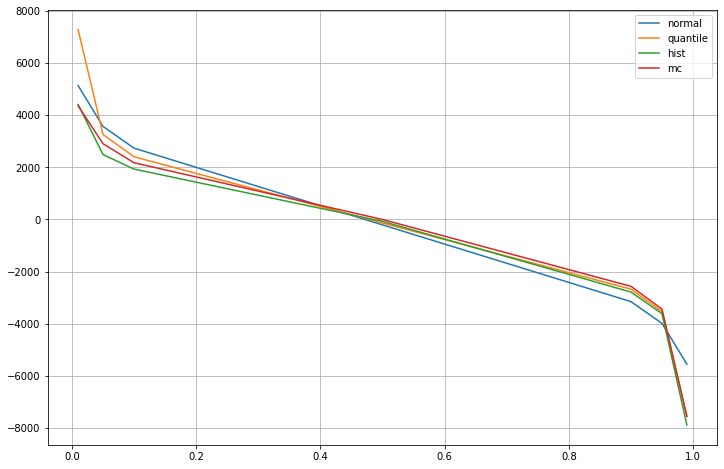

In [9]:
df_var.plot(figsize=(12,8))
plt.grid()

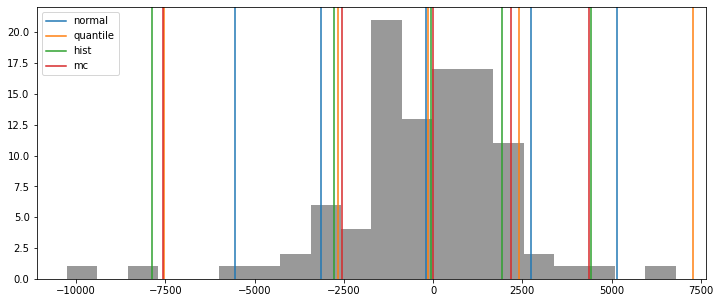

In [10]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# let's look at history
# P&L distribution
cl_p = [0.01, 0.1, 0.5, 0.9, 0.99]

plt.figure(figsize=(12, 5))
plt.hist(ds_pnl, bins=20, color='k', alpha=0.4)

for i, cl in enumerate(cl_p):
    ds_p = df_var.loc[cl]
    for i_k, (k, v) in enumerate(ds_p.items()):
        plt.axvline(v, c=colors[i_k], label=k if i == 0 else None)

plt.legend()
plt.show()

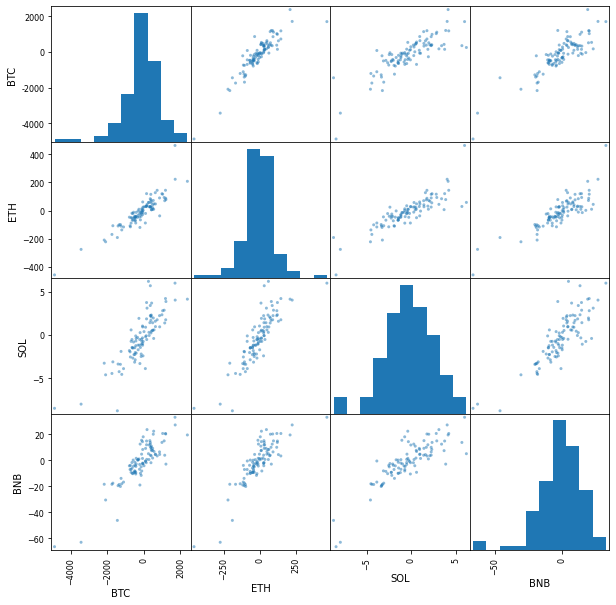

In [11]:
pd.plotting.scatter_matrix(my_var.df_rtrn, figsize=(10,10))
plt.show()